## Job search optimizer

A non-serious attempt to optimize job search strategy using genetic algorithms

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [75]:
# Constants
njobs = 20 # How many jobs
qsd = 0.2   # Spread (sd) of interview performance

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


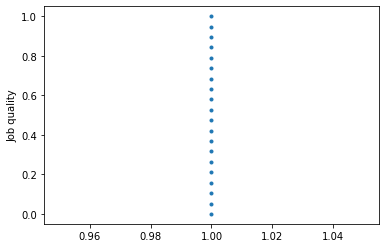

In [108]:
# Init arrays
# th = np.minimum(1,np.maximum(0,np.random.normal(0.5,thsd,njobs))) # normal around 0.5, but bound by [0,1]
th = np.linspace(0,1,njobs) # OK, let's distribute jobs linearly instead
plt.plot(np.ones(th.shape),th,'.');
plt.ylabel('Job quality');

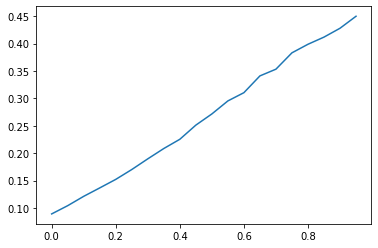

In [111]:
# How E(job quality) changes with q (applicant quality), assuming random sequence and accept first job?
nexp = 2000
q = np.arange(0,1,0.05)
finaljob = np.empty(len(q))

for iq in range(len(q)):
    temp = []
    for iexp in range(nexp):
        res = 0 # No job by default
        shfl = np.random.permutation(len(th))
        for j in range(len(th)): # Try different jobs
            thisth = th[shfl[j]]
            if q[iq]+np.random.normal(0,qsd,1) > thisth: # Acceptance
                res = thisth
                break
        temp.append(res)
    finaljob[iq] = np.mean(temp)
    
plt.plot(q,finaljob);

So basically a sigmoid, saturating at average job quality.

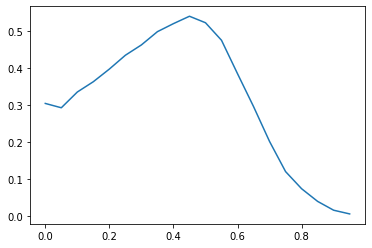

In [119]:
# How E(job quality) changes for a fixed q, but with different hopes?
# The applicant rejects jobs that feel too lowly for them, but gets 0 if no job
nexp = 2000
q = 0.5 # Smack in the middle
h = np.arange(0,1,0.05) # Hope (acceptance threshold)
finaljob = np.empty(len(h))

for ih in range(len(h)):
    temp = []
    for iexp in range(nexp):
        res = 0 # No job by default
        shfl = np.random.permutation(len(th))
        for j in range(len(th)): # Different jobs
            thisth = th[shfl[j]]
            if q+np.random.normal(0,qsd,1) > thisth:
                if h[ih]<thisth: # Job perceived as good (inefficient calculation, but we'll change h next)
                    res = thisth
                    break
        temp.append(res)
    finaljob[ih] = np.mean(temp)
    
plt.plot(h,finaljob);

Note this uptick. So there's a region where being selective about jobs actually helps on average, but then they start rejecting too much, and risk running entire job search without a success. Interestingly, optimal threshould is somewhat around the "true value" of individual, but the job failure rate may be rather high (I don't look into it here).

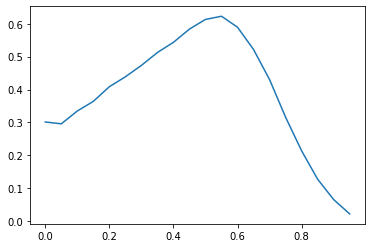

In [121]:
# Now same thing as above E(job quality)(hope)
# but q (interview performance) increases with interviewing (experience)
nexp = 2000
q = 0.5
qimprovement = 0.2
h = np.arange(0,1,0.05) # Hope (acceptance threshold)
finaljob = np.empty(len(h))

for ih in range(len(h)):
    temp = []
    for iexp in range(nexp):
        res = 0 # No job by default
        shfl = np.random.permutation(len(th))
        for j in range(len(th)): # Different jobs
            thisTh = th[shfl[j]]
            if q+np.random.normal(0,qsd,1)+j/len(th)*qimprovement > thisTh: # Job offer
                if h[ih]<thisTh: # Job perceived as good (inefficient calculation, but we'll change h next)
                    res = thisTh
                    break
        temp.append(res)
    finaljob[ih] = np.mean(temp)
    
plt.plot(h,finaljob);

Moves the uptick to the right, and improves final values, not surprisingly. The optimal threshold is now at "average true value", which is something like $q + q'/2$

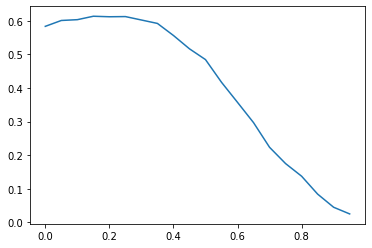

In [201]:
# Now same thing as above E(job quality)(hope),
# q (interview performance) still increases with interviewing (experience), 
# but also hopes decrease linearly (is it a good assumption tho?), from max(th) to minhope
nexp = 2000
q = 0.5
qimprovement = 0.2
minhope = np.arange(0,1,0.05) # Hope (acceptance threshold)
finaljob = np.empty(len(minhope))

for ih in range(len(minhope)):
    temp = []
    for iexp in range(nexp):
        res = 0 # No job by default
        shfl = np.random.permutation(len(th))
        for j in range(len(th)): # Different jobs
            thisTh = th[shfl[j]]
            h = max(th)-(max(th)-minhope[ih])*j/len(th)
            if q+np.random.normal(0,qsd,1)+j/len(th)*qimprovement > thisTh: # Job offer
                if h<thisTh: # Job perceived as good (inefficient calculation, but we'll change h next)
                    res = thisTh
                    break
        temp.append(res)
    finaljob[ih] = np.mean(temp)
    
plt.plot(minhope,finaljob);

In this scenario, the results stay flat for a while, which is nice, as it means that people with impostor syndrome are not punished. Arrogant people are still punished. And it's better actually to be humble towards the end, as $E(0.5)$ is slightly lower here, compared to the previous scenario, which means that if you only go down to your "true value", you are at risk of not finding a job. It's better to dive below your true value towards the end.

But I don't think this approach to hope(j) is realistic. Let's assume that we face a hard deadline, so hope(end)=0. It's also assume that if we get to our top choice, we'll always accept, so hope(0)=1 is safe. The question is about how fast we'd decay, with linear being in the middle, sharp drop in the beginning, and flat followed by a drop being two extremes. We need a family of decaying functions, essentially.

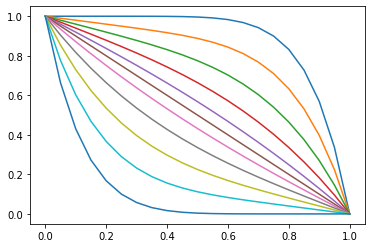

In [193]:
param = np.linspace(-1,1,11)
x = np.linspace(0,1,21)
res = np.empty((len(x),len(param)))

def decayfn(x,param): # param from -1 (slow decay), through 0 (linear), and to 1 (fast decay)
    p = abs(param)
    out = (1-x)*(1-p) + (1-np.power(x,np.power(2,1+p*2)))*p
    if param>0:
        out = 1-np.flip(out)
    return out

for i in range(len(param)):
    res[:,i] = decayfn(x,param[i])

plt.plot(x,res,'-');

Now repeat the hope exercise with different decay speeds:

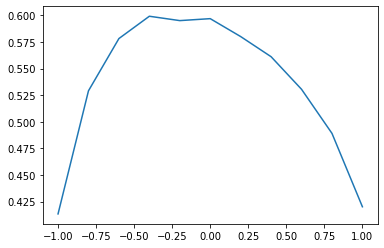

In [209]:
# E(job quality)(hope),
# q (interview performance) increases with interviewing (experience), 
# hope decreases, with different speeds
nexp = 2000
q = 0.5
qimprovement = 0.2
hopedecay = np.linspace(-1,1,11) # Hope decrease speed
finaljob = np.empty(len(hopedecay))

for ih in range(len(hopedecay)):
    temp = []
    hope = decayfn(np.linspace(0,1,njobs),hopedecay[ih])
    for iexp in range(nexp):
        res = 0 # No job by default
        shfl = np.random.permutation(njobs)
        for j in range(njobs): # Different jobs
            thisTh = th[shfl[j]] 
            if q+np.random.normal(0,qsd,1)+j/len(th)*qimprovement > thisTh: # Job offer
                if hope[j]<thisTh: # Job perceived as good (inefficient calculation, but we'll change h next)
                    res = thisTh
                    break
        temp.append(res)
    finaljob[ih] = np.mean(temp)
    
plt.plot(hopedecay,finaljob);

Aha, cool! So, if you are applying to jos at random, it's better to keep rather high hopes at first and reject offers, then drop almost linearly, maybe a bit slower than linearly. Here's the plot of how the optimal hope looked like:

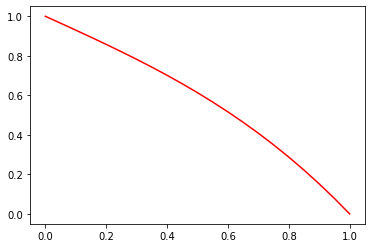

In [213]:
x = np.linspace(0,1,21)
plt.plot(x,decayfn(x,-0.3),'r-');

And now, to final computation. Let's try to optimize both the hope curve, and the *sequence* at which we'll be applying for jobs.

In [304]:
# Helper function for the genetic algorithm
def mypermute(n,m):
    """Permutes m elements of an n-long array"""
    which = np.random.permutation(n)[:m]
    how = np.random.permutation(m)
    out = np.arange(n)
    out[which] = out[which[how]]
    
    return out.tolist()

mypermute(10,3)

[0, 8, 2, 3, 4, 5, 6, 7, 1, 9]

..........

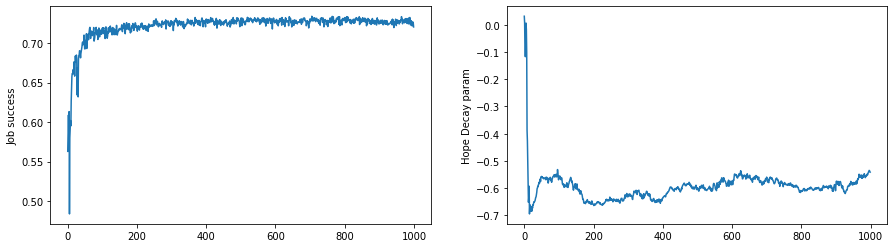

In [360]:
# Iteratively improve job-seeking strategy, going for the best E(finaljob)

nexp = 1000   # New meaning: number of iterations
npop = 50    # How many alternative strategies to explore at each iteration
ntries = 200 # How many times to try every sequence
q = 0.5
qimprovement = 0.2

pop = [None]*npop
hopedecay = np.random.uniform(-1,1,npop)
for ipop in range(npop):
    pop[ipop] = np.random.permutation(njobs)
finaljob = np.empty(npop)
    
success = [] # It's like loss, but the other way around
trace = []
for iexp in range(nexp):
    ntries = min(200,10+iexp) # Adaptive quality: the deeper in, the more accurate estimations we need
    if (iexp % 100)==0:
        print('.',end='')
    for ipop in range(npop):
        hope = decayfn(np.linspace(0,1,njobs),hopedecay[ih])
        shfl = pop[ipop] # Current application sequence
        temp = [] # Result collection
        for itry in range(ntries):
            res = 0 # No job by default
            for j in range(njobs): # Different jobs
                thisTh = th[shfl[j]] 
                if q+np.random.normal(0,qsd,1)+j/len(th)*qimprovement > thisTh: # Job offer
                    if hope[j]<thisTh: # Job perceived as good (inefficient calculation, but we'll change h next)
                        res = thisTh
                        break
            temp.append(res)
        finaljob[ipop] = np.mean(temp) # Success for this strategy
        
    success.append(np.mean(finaljob))
    
    # Evaluate strategies:
    temp = np.argsort(finaljob)
    pop = [pop[_] for _ in temp] # Sort pop by result; best populations are at the end
    hopedecay = hopedecay[temp]
    split = npop // 2
    for ipop in range(split): # Let's replace worst parameters with new ones
        hopedecay[ipop] = hopedecay[np.random.randint(split,npop)] + np.random.normal(0,0.01)
        pop[ipop] = pop[np.random.randint(split,npop)][mypermute(njobs,njobs // 4)]
        # No crossover, which is sad of course
    for ipop in range(split,split + npop//4):
        pop[ipop] = pop[ipop][mypermute(njobs,2)] # Minimal permutation for remaining ones
    hopedecay = np.minimum(1,np.maximum(-1,hopedecay)) # Keep in good limits
    trace.append(np.mean(hopedecay))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1);
plt.plot(success);
plt.ylabel('Job success');
plt.subplot(1,2,2);
plt.plot(trace);
plt.ylabel('Hope Decay param');

Let's look at what we got:

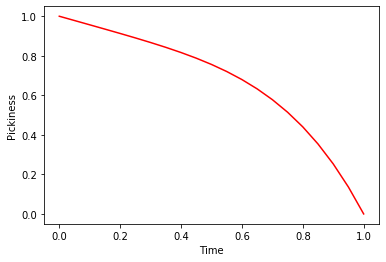

In [366]:
# Optimal hope curve - linear
x = np.linspace(0,1,21)
plt.plot(x,decayfn(x,hopedecay[-1]),'r-');
plt.xlabel('Time');
plt.ylabel('Pickiness');

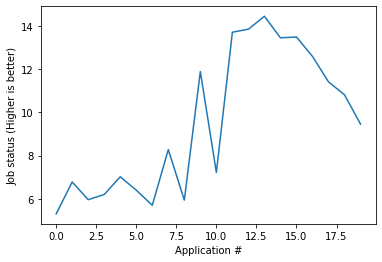

In [367]:
# Application priority curve:
plt.plot(np.mean(np.array(pop),axis=0));
plt.xlabel('Application #');
plt.ylabel('Job status (Higher is better)');